In [1]:
import os
import numpy as np
import pandas as pd
import time
import scanpy as sc
import torch

import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

import sys
sys.path.append('../../')
import scDualGN
sys.path.append('../')
import expri_helper

/jdfssz1/ST_HEALTH/P18Z10200N0124/AI/user/baiyong/anaconda3/envs/mytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dat_path = expri_helper.get_path('wu', dat_ls_file='../expri_data.json')

In [3]:
adata = sc.read_h5ad(dat_path)

In [4]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.highly_variable_genes(adata, n_top_genes=2500)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

In [5]:
#kmeans
# start = time.time()
# z_final, y_pred_lab, model = scDualGN.run_scDualGN(adata, n_cluster=9,n_z=32, batch_size=1024*8,
#                                                    n_epoch_update_pq=5, 
#                                                    n_epochs=30, alpha_dualvae=0.05, beta_daulvae=20, gamma_dualvae=4, eta_klloss=1, nu_centerloss=1, device='cuda:2')
# end = time.time()

# print('running time = {}'.format(end-start))
# alpha_dualvae=0.05, beta_daulvae=20, gamma_dualvae=4, eta_klloss=1, nu_centerloss=1: 

lr, alpha, gamma, nu = 0.01, 0.01, 4, 0.01
print('=====================================')
print('lr:{}, alpha:{}, gamma:{}, nu:{}'.format(lr, alpha, gamma, nu))
start = time.time()
torch.cuda.empty_cache()
scdualgn_model = scDualGN.scDualGN(adata, n_z=32,device='cuda:1', batch_size=1024, verbosity=True, lr=lr).pretrain(alpha=alpha, beta=1, gamma=gamma)
scdualgn_model.cluster(n_cluster=9, eta=1, nu=nu, n_epochs=32)

end = time.time()
print('running time = {}'.format(end-start))

# alpha_dualvae=0.01, beta_daulvae=1,gamma_dualvae=0.5, eta_klloss=5, nu_centerloss=1: acc 0.8545, nmi 0.8361, ari 0.8217
# alpha=0.05, beta=50, gamma=4, eta=1, nu=5: acc 0.7715, nmi 0.7276, ari 0.6787
# alpha=0.05, beta=20, gamma=4, eta=5, nu=5: acc 0.7533, nmi 0.7547, ari 0.7457
# alpha=0.05, beta=50, gamma=4, eta=5, nu=5: acc 0.7716, nmi 0.7278, ari 0.6790

# alpha=0.05, beta=20, gamma=4, eta=1, nu=1(lr schedualed): acc 0.7752, nmi 0.7866, ari 0.7412 
# alpha=0.05, beta=20, gamma=4, eta=5, nu=5(lr schedualed): acc 0.7426, nmi 0.7169, ari 0.6688
# acc 0.8030, nmi 0.7948, ari 0.8037


# acc 0.8129, nmi 0.8232, ari 0.8258, hs 0.8504, cs 0.7977, purity: 0.9085, batch_size=1024
# acc 0.8183, nmi 0.8264, ari 0.8287, hs 0.8532, cs 0.8012, purity: 0.9064, batch_size=512
# acc 0.8006, nmi 0.8199, ari 0.8249, hs 0.8457, cs 0.7956, purity: 0.9084

INFO:scDualGN.run:dual-VAE pretrain start...


lr:0.01, alpha:0.01, gamma:4, nu:0.01


INFO:scDualGN.run:Epoch 1/50,Overall loss:1288.1466,MSE:1076.5283,MSE1:52.0979,KL: 322.6734
INFO:scDualGN.run:Epoch 2/50,Overall loss:878.3470,MSE:873.7278,MSE1:0.2539,KL: 360.3404
INFO:scDualGN.run:Epoch 3/50,Overall loss:843.5588,MSE:839.6434,MSE1:0.2536,KL: 290.1088
INFO:scDualGN.run:Epoch 4/50,Overall loss:820.5024,MSE:817.0440,MSE1:0.2449,KL: 247.9054
INFO:scDualGN.run:Epoch 5/50,Overall loss:801.5437,MSE:798.3462,MSE1:0.2410,KL: 223.3400
INFO:scDualGN.run:Epoch 6/50,Overall loss:788.1183,MSE:785.0915,MSE1:0.2306,KL: 210.4558
INFO:scDualGN.run:Epoch 7/50,Overall loss:779.1655,MSE:776.2595,MSE1:0.2203,KL: 202.4803
INFO:scDualGN.run:Epoch 8/50,Overall loss:773.0883,MSE:770.2630,MSE1:0.2112,KL: 198.0351
INFO:scDualGN.run:Epoch 9/50,Overall loss:769.4596,MSE:766.6829,MSE1:0.2055,KL: 195.4576
INFO:scDualGN.run:Epoch 10/50,Overall loss:767.8031,MSE:765.0423,MSE1:0.2044,KL: 194.3240
INFO:scDualGN.run:Epoch 11/50,Overall loss:769.9697,MSE:767.3343,MSE1:0.1874,KL: 188.5552
INFO:scDualGN.ru

acc 0.7941, nmi 0.8167, ari 0.8211, hs 0.8439, cs 0.7913, purity: 0.9057
running time = 495.82518887519836


In [6]:
adata.obs['celltype_scDualGN']=scdualgn_model.y_pred_label
adata.obsm['X_z']=scdualgn_model.z

In [7]:
sc.pp.neighbors(adata,n_neighbors=20,use_rep="X_z") 
sc.tl.umap(adata)

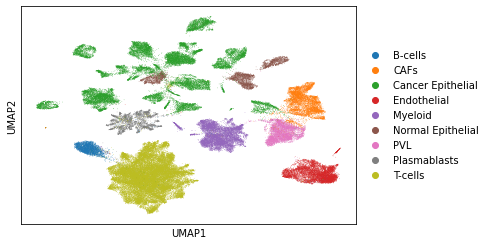

In [8]:
sc.pl.umap(adata, color=['celltype_str'],title='')

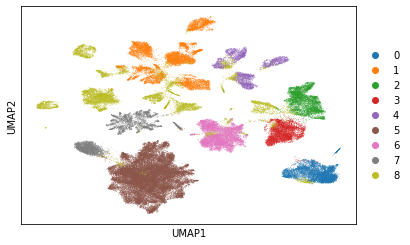

In [9]:
adata.obs['celltype_scDualGN']=scdualgn_model.y_pred_label
adata.obs['celltype_scDualGN'] = adata.obs['celltype_scDualGN'].astype('category')
sc.pl.umap(adata, color=['celltype_scDualGN'],title='')